### 1.	Сформируйте тренировочный датасет. 

In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import wfdb
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.callbacks import EarlyStopping
import autokeras as ak
import os



# Установка seed для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)

# 1. Загрузка и подготовка датасета MIT-BIH Arrhythmia Database

# Список записей (используем первые 10 для демонстрации)
# records = [str(i) for i in range(100, 121) if i not in [110, 120]]
records = [file.split('.')[0] for file in os.listdir('lab6/mitdb') if file.endswith('.hea')]

# Функция для загрузки сигналов и аннотаций
def load_data(records, sampfrom=0, sampto=650000):
    signals = []
    labels = []
    
    for record in tqdm(records):
        # Загрузка сигнала
        signal = wfdb.rdrecord(f'lab6/mitdb/{record}', sampfrom=sampfrom, sampto=sampto, channels=[0]).p_signal.flatten()
        
        # Загрузка аннотаций
        annotation = wfdb.rdann(f'lab6/mitdb/{record}', 'atr', sampfrom=sampfrom, sampto=sampto)
        
        # Извлечение QRS-комплексов и меток
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - 90)
            end = min(len(signal), annotation.sample[i] + 90)
            
            segment = signal[start:end]
            if len(segment) == 180:  # Убедимся, что все сегменты одинаковой длины
                signals.append(segment)
                labels.append(annotation.symbol[i])
    
    return np.array(signals), np.array(labels)

# Загрузка данных (это может занять некоторое время)
signals, labels = load_data(records)


100%|████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 68.88it/s]


In [2]:
pd.Series(labels).value_counts()

N    75033
L     8073
R     7257
V     7129
/     7027
A     2546
+     1251
f      982
F      802
~      614
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: count, dtype: int64

In [3]:
# Фильтрация только основных классов
main_classes = ['N', 'L', 'R', 'V', 'A']
mask = np.isin(labels, main_classes)
signals_filtered = signals[mask]
labels_filtered = labels[mask]

# Преобразование меток в числовой формат
label_map = {'N': 0, 'L': 1, 'R': 2, 'V': 3, 'A': 4}
y = np.array([label_map[label] for label in labels_filtered])
X = signals_filtered

# Нормализация данных
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

# Разделение на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Преобразование в формат для LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# One-hot кодирование меток
y_train = utils.to_categorical(y_train, num_classes=len(main_classes))
y_test = utils.to_categorical(y_test, num_classes=len(main_classes))

### 2.	Постройте нейронную сеть с эффектом памяти (LSTM) и примените механизм внимания, 

In [4]:
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam

class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"), 
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        # Добавляем проекционный слой, если размерность входа не совпадает с embed_dim
        if input_shape[-1] != self.embed_dim:
            self.dense_proj = layers.Dense(self.embed_dim)
        else:
            self.dense_proj = lambda x: x
        super().build(input_shape)

    def call(self, inputs):
        # Проекция входных данных
        inputs_proj = self.dense_proj(inputs)
        
        # Self-attention
        attn_output = self.att(inputs_proj, inputs_proj)
        attn_output = self.dropout1(attn_output, training=True)  # Всегда training=True для простоты
        out1 = self.layernorm1(inputs_proj + attn_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=True)
        return self.layernorm2(out1 + ffn_output)

def create_improved_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Временные особенности через LSTM
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    
    # Проекция в нужную размерность для Transformer
    x = layers.Dense(32)(x)
    
    # Механизм внимания (Transformer Encoder)
    x = TransformerEncoder(embed_dim=32, num_heads=4, ff_dim=64)(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Классификация
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Используем Adam оптимизатор с learning rate 0.001
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy', 
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')])
    
    return model

In [5]:
model = create_improved_model((X_train.shape[1], X_train.shape[2]), len(main_classes))
model.summary()

# Колбэк для ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 180, 128)       │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 180, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 180, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 180, 32)        │        21,120 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,645 (393.14 KB)

 Trainable params: 100,645 (393.14 KB)

 Non-trainable params: 0 (0.00 B)

#### 3.	Обучите ее классифицировать классы по заданной ЭКГ. Постройте матрицу ошибок (confusion matrix). 

In [6]:
history = model.fit(
    X_train, y_train,
    epochs=7,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/7
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 339s 336ms/step - accuracy: 0.8524 - loss: 0.4781 - precision: 0.8898 - recall: 0.8124 - val_accuracy: 0.9613 - val_loss: 0.1401 - val_precision: 0.9642 - val_recall: 0.9582
Epoch 2/7
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 350s 349ms/step - accuracy: 0.9645 - loss: 0.1403 - precision: 0.9681 - recall: 0.9612 - val_accuracy: 0.9704 - val_loss: 0.1082 - val_precision: 0.9733 - val_recall: 0.9687
Epoch 3/7
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 347s 347ms/step - accuracy: 0.9730 - loss: 0.1022 - precision: 0.9756 - recall: 0.9707 - val_accuracy: 0.9725 - val_loss: 0.0890 - val_precision: 0.9757 - val_recall: 0.9698
Epoch 4/7
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 343s 343ms/step - accuracy: 0.9765 - loss: 0.0857 - precision: 0.9786 - recall: 0.9746 - val_accuracy: 0.9788 - val_loss: 0.0701 - val_precision: 0.9801 - val_recall: 0.9778
Epoch 5/7
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 344s 344ms/step - accuracy: 0.9806 - loss: 0.0711 - precision: 0.9822 - recall: 0.9790 - val_accura

In [21]:
model.save('lab6/transformer_model.h5')  # Creates a directory

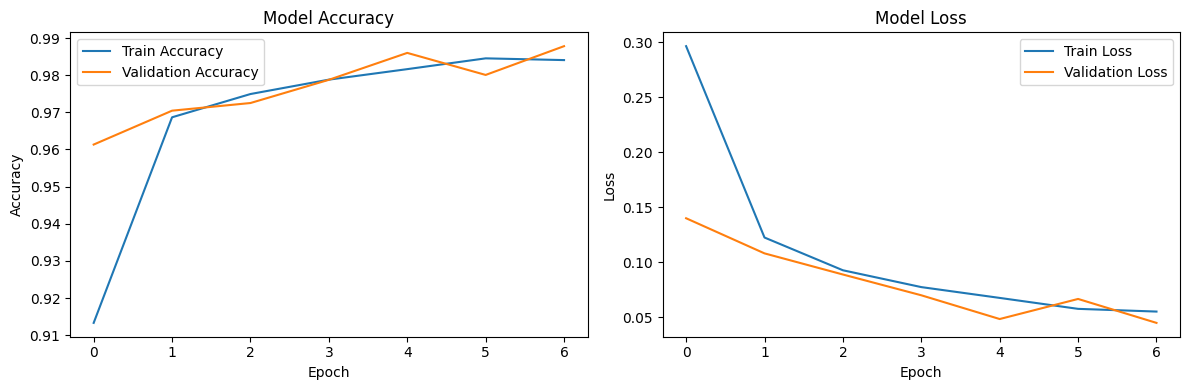

In [7]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [8]:
# Оценка на тестовых данных
results = model.evaluate(X_test, y_test, verbose=0)

# Метрики возвращаются в порядке: loss, accuracy, precision, recall
loss = results[0]
accuracy = results[1]
precision = results[2]
recall = results[3]

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')

Test Loss: 0.0506
Test Accuracy: 0.9873
Test Precision: 0.9876
Test Recall: 0.9872


In [9]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Построение матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

626/626 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step


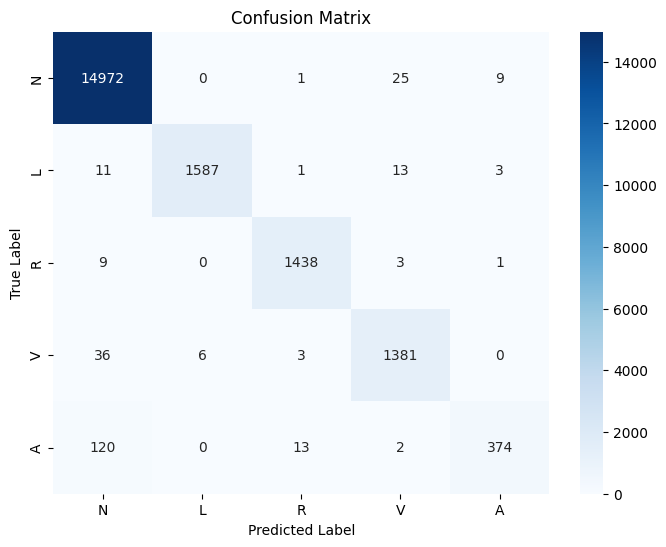

              precision    recall  f1-score   support

           N       0.99      1.00      0.99     15007
           L       1.00      0.98      0.99      1615
           R       0.99      0.99      0.99      1451
           V       0.97      0.97      0.97      1426
           A       0.97      0.73      0.83       509

    accuracy                           0.99     20008
   macro avg       0.98      0.93      0.96     20008
weighted avg       0.99      0.99      0.99     20008



In [10]:
plot_confusion_matrix(y_test_classes, y_pred_classes, main_classes)

# Вывод отчета о классификации
print(classification_report(y_test_classes, y_pred_classes, target_names=main_classes))

### 4.	Проведите эксперименты по заданию на AutoML решении. Сравните результаты.

#### lightautoml

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
# Преобразование в 2D (для TPOT и LightAutoML)
X_2d = X.reshape(X.shape[0], -1)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X_2d, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_test = X_test.reshape(X_train.shape[0], -1)

In [14]:
import pandas as pd
import numpy as np
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.metrics import classification_report

# 1. Подготовка данных
def prepare_data(X, y=None):
    df = pd.DataFrame(X)
    df.columns = [f'f_{i}' for i in range(df.shape[1])]
    if y is not None:
        df['target'] = y
    return df

train_data = prepare_data(X_train, y_train)
test_data = prepare_data(X_test)

# 2. Проверка данных
print("Проверка данных:")
print("Размер train:", train_data.shape)
print("Размер test:", test_data.shape)
print("NaN в train:", train_data.isna().sum().sum())
print("NaN в test:", test_data.isna().sum().sum())
print("Уникальные значения target:", np.unique(y_train))

# 3. Настройка задачи и AutoML
task = Task('multiclass')

automl = TabularAutoML(
    task=task,
    timeout=300,  # 5 минут
    cpu_limit=4,
    general_params={
        'use_algos': [['lgb', 'cb']],  # Только LightGBM и CatBoost
        'default_algos': ['lgb', 'cb']
    },
    reader_params={
        'cv': 3,
        'random_state': 42,
    }
)



Проверка данных:
Размер train: (80030, 181)
Размер test: (20008, 180)
NaN в train: 0
NaN в test: 0
Уникальные значения target: [0 1 2 3 4]


In [15]:
# Правильные роли для LightAutoML 0.4.1
roles = {
    'target': 'target',
    'drop': []  # Явно указываем, что не нужно удалять никакие колонки
}

oof_pred = automl.fit_predict(
    train_data,
    roles=roles,
    verbose=1
)

# 5. Предсказание
test_pred = automl.predict(test_data)
y_pred = test_pred.data.argmax(axis=1)

print("\nРезультаты LightAutoML:")
print(classification_report(y_test, y_pred, target_names=main_classes))

[22:15:05] Stdout logging level is INFO.
[22:15:05] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[22:15:05] Task: multiclass

[22:15:05] Start automl preset with listed constraints:
[22:15:05] - time: 300.00 seconds
[22:15:05] - CPU: 4 cores
[22:15:05] - memory: 16 GB

[22:15:05] Train data shape: (80030, 181)

[22:15:21] Layer 1 train process start. Time left 284.56 secs
[22:15:44] Selector_LightGBM fitting and predicting completed
[22:15:44] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[22:16:34] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.03499325986954408
[22:16:34] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[22:16:34] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[22:18:42] Time limit exceeded after calculating fold 1

[22:18:42] Fitting Lvl_0_Pipe_0_Mod_1_CatBoost finished. score = -0.03470790229368929
[22:18:42] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[22:18:42] Time left 8

#### TPOT

In [16]:
# from tpot import TPOTClassifier


# tpot = TPOTClassifier(
#     generations=3, 
#     population_size=10,
#     cv=3,
#     random_state=42,
#     verbosity=2,
#     n_jobs=-1
# )

# tpot.fit(X_train, y_train)

# y_pred_tpot = tpot.predict(X_test)
# print(classification_report(y_test, y_pred_tpot, target_names=main_classes))

In [17]:
from tpot import TPOTClassifier
from sklearn.metrics import classification_report

# Оптимизированная конфигурация TPOT
tpot = TPOTClassifier(
    generations=2,
    population_size=5,
    cv=2,
    random_state=42,
    verbosity=2,
    n_jobs=-1,
    config_dict='TPOT light',
    early_stop=3,
    max_time_mins=10,
    warm_start=True
)



tpot.fit(X_train, y_train)

# Предсказание и оценка
y_pred_tpot = tpot.predict(X_test)
print("\nTPOT Classification Report:")
print(classification_report(y_test, y_pred_tpot, target_names=main_classes))

# Сохраняем лучший пайплайн
tpot.export('tpot_optimized_pipeline.py')

Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/5 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9856303886042734

12.65 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=21, p=2, weights=distance)

TPOT Classification Report:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99     15007
           L       0.99      0.99      0.99      1615
           R       0.99      0.99      0.99      1451
           V       0.98      0.97      0.97      1426
           A       0.94      0.83      0.88       509

    accuracy                           0.99     20008
   macro avg       0.98      0.95      0.97     20008
weighted avg       0.99      0.99      0.99     20008



#### fedot

In [18]:
tpot.fitted_pipeline_

Pipeline(steps=[('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=21, weights='distance'))])

In [19]:
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum

from sklearn.preprocessing import StandardScaler


# Предварительное масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Настройка задачи
task = Task(TaskTypesEnum.classification)

# Инициализация FEDOT
fedot_model = Fedot(
    problem='classification',
    metric='roc_auc',
    timeout=2,  # минут
    n_jobs=-1,
    preset='light',
)

# Обучение
fedot_model.fit(
    features=X_train_scaled, target=y_train
)

# Предсказание
y_pred_fedot = fedot_model.predict(features=X_test_scaled)

# Оценка
print("\nFEDOT Results:")
print(classification_report(y_test, y_pred_fedot, target_names=main_classes))

2025-04-18 22:32:05,366 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-18 22:33:21,835 - ApiComposer - Initial pipeline was fitted in 76.4 sec.
2025-04-18 22:33:21,856 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 382.2 sec.
2025-04-18 22:33:21,871 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 2 min. Set of candidate models: [].
2025-04-18 22:33:21,966 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 382.216635 sec.
2025-04-18 22:33:22,583 - ApiComposer - Hyperparameters tuning started with 1 min. timeout
2025-04-18 22:39:50,047 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}
logit - {}
catboost - {'n_jobs': 12, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_l

#### MLFlow

In [36]:
import mlflow
from mlflow.pyfunc import PythonModel

class LightAutoMLWrapper(PythonModel):
    def __init__(self, automl):
        self.automl = automl
        
    def predict(self, context, model_input):
        predictions = self.automl.predict(model_input).data
        
        # Convert NumpyDataset to JSON-serializable format
        return np.argmax(predictions, axis=1) #.tolist() #predictions.data[:, 0]

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("ppa_lab")

/Users/vladimir/miniconda3/envs/py39_jupyter/lib/python3.9/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


<Experiment: artifact_location='/Users/vladimir/Desktop/University/ppa/labs/artifacts/3', creation_time=1744904699558, experiment_id='3', last_update_time=1744904699558, lifecycle_stage='active', name='ppa_lab', tags={}>

In [37]:
lab = 'lr6'
# Save to MLflow
with mlflow.start_run(run_name=lab):
    wrapped_model = LightAutoMLWrapper(automl)

    mlflow.pyfunc.log_model(
        artifact_path=lab,
        python_model=wrapped_model,
    )

2025/04/19 00:12:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run lr6 at: http://localhost:5000/#/experiments/3/runs/d3121b2abb66498b8630e0f123abd550
🧪 View experiment at: http://localhost:5000/#/experiments/3


In [38]:
# проверка корректности выгрузки модели из mlflow
run_id = 'd3121b2abb66498b8630e0f123abd550'
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/{lab}")
predictions_mlflow = loaded_model.predict(test_data)

In [43]:
# сохранение артефактов локально
mlflow.artifacts.download_artifacts(
    run_id=run_id,
    artifact_path=lab, 
    dst_path="./downloaded_model"
)

'/Users/vladimir/Desktop/University/ppa/labs/downloaded_model/lr6'

In [44]:
# !mlflow models serve -m "./downloaded_model/lr6" --port 1234 --no-conda
# проверка сервиса
!curl http://localhost:1234/ping

In [45]:

import requests

# отправка post запроса к развернутому сервису
response = requests.post(
    "http://localhost:1234/invocations",
    json={"dataframe_records": test_data.to_dict(orient="records")}
)


In [46]:
predictions_mlflow_server = response.json()['predictions']

In [41]:
test_predict = automl.predict(test_data).data#.flatten()
test_predict = np.argmax(test_predict, axis=1)

In [42]:
np.allclose(predictions_mlflow, test_predict)

True

In [47]:
np.allclose(predictions_mlflow_server, test_predict)

True

Сохранение модели в mlflow и ее развертывание с помощью mlflow server прошло корректно, резульаты работы модели совпадают с исходными